In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import os
import numpy as np
import math
import pandas as pd
#from functools import reduce
#import random

Functions

In [3]:
def calculate_velocity_central(x, y, dt, gap):
    velocity = np.zeros(math.ceil(len(x) / gap) -2 )
    for i in range(gap, len(x) - gap, gap):
        velocity[(i-gap)//gap] = np.sqrt((x[i+gap] - x[i-gap])**2 + (y[i+gap] - y[i-gap])**2) / (2 * gap * dt)
    return velocity


def calculate_angular_velocity_central(x, y, dt, gap):
    vx = np.zeros(math.ceil(len(x) / gap) -2 )
    vy = np.zeros(math.ceil(len(x) / gap) -2 )
    for i in range(gap, len(x) - gap, gap):
        vx[(i-gap)//gap] = (x[i+gap] - x[i]) / (1.0 * gap * dt)
        vy[(i-gap)//gap] = (y[i+gap] - y[i]) / (1.0 * gap * dt)
    cosijk = np.zeros_like(vx[:-1])
    for i in range(len(cosijk) ):
        cosijk[i] = vx[i]*vx[i+1] + vy[i]*vy[i+1]
        cosijk[i]  /= ( math.sqrt(vx[i]**2 + vy[i]**2)  + 1e-10)
        cosijk[i]  /= ( math.sqrt(vx[i+1]**2 + vy[i+1]**2) + 1e-10 )
    
    theta = np.arccos(cosijk)
    angular_velocity = theta / (1.0 * gap * dt)
    return np.abs(angular_velocity )


def find_events(angular_velocity, threshold):
    events = np.where(angular_velocity >= threshold)[0]
    return events
    
    
def identify_merging_trajectories(df1, df2, distance_threshold=5.0,frame_threshold = 5):
    
    distance = ((df1['x_moving_average'].iloc[-1] - df2['x_moving_average'].iloc[0])**2 + (df1['y_moving_average'].iloc[-1] - df2['y_moving_average'].iloc[0])**2)**0.5
    frame_gap = df2['frame'].iloc[0] - df1['frame'].iloc[-1]
    if distance <= distance_threshold and frame_gap <= frame_threshold and frame_gap > 0 :
        return True
    else:
        return None
    

def plot_Trajectory_Panel(df, key, dir_name, gap1, show_plot = False ) :
    fig = plt.figure(figsize=(10,6))
    gs = fig.add_gridspec(2, 2)
    axs = []
    #axs.append(fig.add_subplot(gs[:, 0]))
    axs.append(fig.add_subplot(gs[0, 0]))
    axs.append(fig.add_subplot(gs[0, 1]))
    axs.append(fig.add_subplot(gs[1, 0]))
    axs.append(fig.add_subplot(gs[1, 1]))

    cmap = plt.get_cmap('viridis')
    n_colors = cmap.N
    colors1 = cmap(np.linspace(0, 1, len(df['time']) ))
    norm = colors.Normalize(vmin = df['velocity'].min(), vmax = df['velocity'].max())
    normalized_v = norm(df['velocity'])
    colors2 = cmap(normalized_v)
    for i in range(len(df) - 1):
        axs[0].plot(df['x_moving_average'].iloc[i:i+2], df['y_moving_average'].iloc[i:i+2], color = colors2[i] , linestyle = "-")
        axs[1].plot(df['time'].iloc[i:i+2], df['velocity'].iloc[i:i+2], label='Velocity',color=colors2[i], linestyle="-")
        axs[2].scatter(df['angular_velocity'].iloc[i:i+2], df['velocity'].iloc[i:i+2], label='ω vs v',color=colors2[i], s=3)
        axs[3].plot(df['time'].iloc[i:i+2], df['angular_velocity'].iloc[i:i+2], label='Angular Velocity',color=colors2[i], linestyle="-")

    axs[0].scatter( df['x_moving_average'].iloc[0], df['y_moving_average'].iloc[0], marker="x", color='red')
    axs[0].set_aspect("equal", "box")
    axs[0].set_xlabel("X-coordinate (µm)")
    axs[0].set_ylabel("Y-coordinate (µm)")

    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Velocity (µm/s)")
    traj_vMean = df['velocity'].mean()
    comment = f'vMean={traj_vMean:.3f}'
    axs[1].annotate(comment, xy=(0.95, 0.95), xycoords='axes fraction', fontsize=8, ha='right', va='top')

    axs[2].set_xlabel("Angular Velocity  (rad/s)")
    axs[2].set_ylabel("Velocity (µm/s)")

    axs[3].set_xlabel("Time (s)")
    axs[3].set_ylabel("Angular Velocity  (rad/s)")

    plt.suptitle(key)
    plt.savefig(f"{dir_name}/{key}.png",dpi=300)
    plt.tight_layout()
    if show_plot:
        plt.show()
        return
    plt.clf()
    plt.close(fig)
    plt.close('all')
        
def calculate_Histogram_Mean_STD (data, n_bin):

    # Calculate mean and standard deviation
    hist, bins = np.histogram(data, bins=n_bin, range=(0, 10), density=True)
    mean= np.mean(data)
    std_dev = np.std(data)
    bin_widths = np.diff(bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    weighted_mean = np.sum(hist * bin_centers * bin_widths)
    weighted_std = np.sqrt(sum(hist * (bin_centers - weighted_mean)**2 * bin_widths) / sum(hist * bin_widths))
    return mean, std_dev, weighted_mean, weighted_std



Parameters and Initializations

In [4]:
tag = "ficoll5"
directory = "."
numInputFiles = 1
generateTrajectories = False
removeTrajectories = True
largeWindowMovingAverage = False
movingAverageGap = 7

spatialScaling = 340.0/ 1280
temporalScaling = 1.0 / 30 # 30 frames per second
standingVelocity_Threshold = 0.5 # in µm/s
standingDuration_Threshold = 20 # in frames
#mergingDistance_threshold = 0.0 # currently no merging happens
#mergingFrame_threshold = 0

# Initializations

numberOfFilteredTrajectories = 0
all_filteredParticles_df = {}
merged_pairs = []


In [5]:

file_list = os.listdir(directory)
# Create the tag directory if it doesn't exist and change to it
if not os.path.exists(tag):
    os.makedirs(tag)

#numInputFiles = len([file for file in file_list if file.startswith(tag) and file.endswith(".txt")])
for index in range(1, numInputFiles + 1 ):
    file_name = f"{tag}_{index}.txt"
    dir_name = f"{tag}/{tag}_{index}"
    if not os.path.exists(dir_name):
            os.makedirs(dir_name)
    try:
        with open(file_name, "r") as input_file:
            data = input_file.readlines()
            
    except FileNotFoundError:
        print(f"File '{file_name}' not found. Skipping to the next file.")
        continue

    # Split data into separate particles
    particles = {}
    particles_ID = []
    for line in data:
        #print(line)
        particle,exp_angular_velocity ,exp_velocity,time, x, y = line.strip().split()
        if particle not in particles:
            particles[particle] = []
        particles[particle].append((float(time), float(exp_velocity), float(exp_angular_velocity), float(x),float(y) ))
        
    # Convert the particle data into a Pandas dataframe
    #particle_data_pandas = pd.DataFrame.from_dict(particles)
    #particle_data_manual = []
    dict_particles_df = {}
    for key, value in particles.items():
        df = pd.DataFrame(np.array(value), columns=['time', 'exp_velocity', 'exp_angular_velocity', 'x', 'y'])
        df = df.sort_values(by = 'time')
        df = df * (temporalScaling , spatialScaling/ temporalScaling, 1.0/ temporalScaling , spatialScaling, spatialScaling)
        df['frame'] = (df['time'] / temporalScaling ).astype(int)
        df = df.reset_index(drop=True)
        df['x_moving_average'] = df['x'].rolling(window = movingAverageGap, min_periods=1 ).mean()
        df['y_moving_average'] = df['y'].rolling(window = movingAverageGap, min_periods=1 ).mean()
        
        velocity = pd.DataFrame({'velocity': calculate_velocity_central( df['x_moving_average'], df['y_moving_average'], temporalScaling, 1) })
        df['velocity'] = pd.concat([pd.Series([np.nan]), velocity['velocity'], pd.Series([np.nan])], ignore_index=True)

        angular_velocity = pd.DataFrame({'angular_velocity':calculate_angular_velocity_central(df['x_moving_average'], df['y_moving_average'], temporalScaling, 1 )})
        df['angular_velocity'] = pd.concat([pd.Series([np.nan]), angular_velocity['angular_velocity'], pd.Series([np.nan])], ignore_index=True)
        
        df.insert(0, 'particle', key)
        df = df.dropna()

        dict_particles_df[key] = df

        #print(angular_velocity.shape)
    

dict_particles_df['5'].head()



,particle,time,exp_velocity,exp_angular_velocity,x,y,frame,x_moving_average,y_moving_average,velocity,angular_velocity
1,5,0.050000,5.073609,30.254243,145.574506,2.371769,1,145.517271,2.356516,1.742559,1.473861
2,5,0.083333,2.239187,10.624524,145.664252,2.451823,2,145.566264,2.388285,1.648699,8.826132
3,5,0.116667,3.605133,24.659617,145.744590,2.491847,3,145.610846,2.414175,1.573047,1.477654
4,5,0.150000,4.550912,14.331911,145.875854,2.476767,4,145.663847,2.426694,1.541021,6.981234
5,5,0.183333,3.290771,59.850307,145.942299,2.507124,5,145.710256,2.440099,1.401759,3.680427


Filter trajectories that are not moving for a while

In [6]:
if removeTrajectories == True :
    particles_copy = dict_particles_df.copy()
    for particle, particle_data in particles_copy.items():
        #print(particle_data)
        rolling_velocity = particle_data['velocity'].rolling(window = standingDuration_Threshold,min_periods=1).mean()
        is_below_threshold = rolling_velocity > standingVelocity_Threshold
        dict_particles_df[particle]['is_moving'] = is_below_threshold

        if not is_below_threshold.all() :
            all_filteredParticles_df[particle] = dict_particles_df[particle]
            del dict_particles_df[particle]
            numberOfFilteredTrajectories += 1
        #print(all_below_threshold)
    
print(dict_particles_df.keys() )
dict_particles_df['25004'].head()

dict_keys(['5', '8', '15', '16', '20', '37', '47', '50', '56', '58', '63', '77', '102', '105', '110', '114', '138', '141', '151', '158', '167', '168', '170', '171', '172', '173', '174', '175', '179', '180', '188', '226', '227', '241', '242', '259', '264', '265', '269', '284', '285', '298', '302', '303', '304', '308', '309', '317', '318', '319', '321', '327', '330', '331', '339', '342', '343', '354', '362', '366', '370', '387', '390', '401', '404', '409', '412', '426', '435', '444', '566', '621', '628', '646', '699', '701', '802', '806', '821', '832', '878', '915', '938', '1017', '1074', '1084', '1122', '1302', '1309', '1347', '1422', '1431', '1504', '1545', '1585', '1622', '1623', '1626', '1637', '1645', '1660', '1700', '1760', '1898', '1914', '1945', '2013', '2039', '2042', '2060', '2100', '2102', '2116', '2148', '2167', '2293', '2314', '2386', '2403', '2452', '2459', '2481', '2530', '2586', '2608', '2630', '2669', '2670', '2731', '2737', '2752', '2783', '2811', '2815', '2827', '2849'

,particle,time,exp_velocity,exp_angular_velocity,x,y,frame,x_moving_average,y_moving_average,velocity,angular_velocity,is_moving
1,25004,35.683333,30.581043,14.558504,298.572172,21.831628,1070,298.505748,22.236106,12.693368,1.875954,True
2,25004,35.716667,28.000324,22.693160,298.868330,20.973823,1071,298.626608,21.815345,13.514558,0.728597,True
3,25004,35.750000,33.691932,18.090012,299.248997,20.068360,1072,298.782206,21.378599,14.381391,1.238108,True
4,25004,35.783333,32.365342,9.902139,299.556263,19.026733,1073,298.937017,20.908226,13.691456,2.563207,True
5,25004,35.816667,1.888310,53.399750,299.818207,18.561651,1074,299.083882,20.517130,11.525134,0.896296,True


Merge the particles that are in the same neighborhood

In [7]:
keys1 = list(dict_particles_df.keys())
keys2 = list(dict_particles_df.keys())
for i in keys1:
    for j in keys2:
        df1 = dict_particles_df[i]
        df2 = dict_particles_df[j]
        merged_df = identify_merging_trajectories(df1, df2)    # add distance_threshold and frame_threshold to the function based on your need
        if merged_df is not None:
            merged_pairs.append((i,j))

for pair in np.arange(len(merged_pairs)-1,-1,-1) :
            
    df1 = dict_particles_df[merged_pairs[pair][0]]
    df2 = dict_particles_df[merged_pairs[pair][1]]
    merged_df = pd.concat([df1, df2], ignore_index=True)
    dict_particles_df[merged_pairs[pair][0]] = merged_df
    del dict_particles_df[merged_pairs[pair][1]]
del merged_df
        

Example of a merge

In [8]:
dict_particles_df['309'].iloc[78:80]

,particle,time,exp_velocity,exp_angular_velocity,x,y,frame,x_moving_average,y_moving_average,velocity,angular_velocity,is_moving
78,309,2.65,12.106373,15.298899,243.830235,106.325964,79,243.781707,106.673381,2.378348,4.740050,True
79,2039,2.75,22.972975,29.063588,243.225449,108.754551,82,243.341300,108.910366,7.942146,11.243518,True


Plot sample trajectory

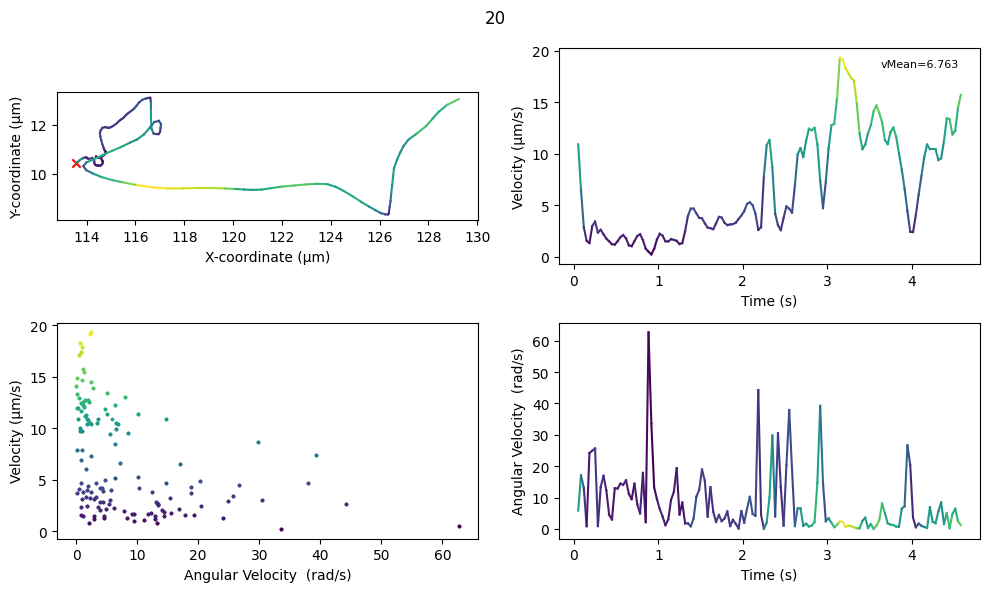

In [9]:
df = dict_particles_df['20']
plot_Trajectory_Panel(df, '20', dir_name, 1 , show_plot= True)

Plot all trajectories
(WARNING: THIS MIGHT TAKE A WHILE)

In [ ]:
if generateTrajectories:
    for key, df in dict_particles_df.items():
        plot_Trajectory_Panel(df, key, dir_name, 1, show_plot= False )